In [1]:
from __future__ import print_function
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In this notebook, we will work on the PyTorch [first tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) without considering GPU related stuff since I don't have one. Mainly we will cover the following topics :

* Tensors and Autograd
* Defining a neural network, a loss, an optimizer
* Defining and training a neural network on an image classification task

# 1. [What is PyTorch ?](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py)
### 1.1 Tensors

Tensors are similar to numpy ndarrays, with the addition being that they can be used on GPUs to accelerate computing. They are multi dimensional matrices containing elements of a single data type. One can create tensors with different initalizations (zeros, random, empty tensor, from array value) or from another tensor (the source tensors properties will be reused unless they are overriden). 

In [3]:
test_size = (3, 2)

x = torch.empty(test_size) #empty initialization
print(x)

x = torch.zeros(test_size, dtype=torch.long) #zeros with specified dtype
print(x)
x = x.new_ones(test_size) #ones with dtype and device coming from the original tensor
print(x)

x = torch.rand(test_size) #random initialization
print(x)
x = torch.randn_like(x, dtype=torch.float) #random with the same size as the original tensor
print(x)

tensor([[9.8091e-45, 0.0000e+00],
        [0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00]])
tensor([[0, 0],
        [0, 0],
        [0, 0]])
tensor([[1, 1],
        [1, 1],
        [1, 1]])
tensor([[0.4124, 0.2444],
        [0.8935, 0.9392],
        [0.6305, 0.9676]])
tensor([[-0.5739,  1.0469],
        [ 0.8922, -0.6686],
        [-1.2772, -0.5704]])


### 1.2 Operations

Operations between tensors can be written in different ways. They also can be done in place or create a new result tensor.

In [4]:
y = torch.rand(test_size)

#Any operation that mutates a tensor in-place is post-fixed with an _
y.add_(x)
print(y)

#Provide result tensor
result = torch.empty(test_size) 
torch.add(x,y, out = result)
print(result)

result = x + y #Basic syntax 1
print(result)

result = torch.add(x,y) #Basic syntax 2
print(result)

tensor([[-0.5046,  1.2974],
        [ 1.4541, -0.0604],
        [-1.2025, -0.1590]])
tensor([[-1.0785,  2.3443],
        [ 2.3463, -0.7289],
        [-2.4797, -0.7295]])
tensor([[-1.0785,  2.3443],
        [ 2.3463, -0.7289],
        [-2.4797, -0.7295]])
tensor([[-1.0785,  2.3443],
        [ 2.3463, -0.7289],
        [-2.4797, -0.7295]])


We can also reshape tensors and slice them as in numpy.

In [6]:
# Indexing
print(y[1,:])
print(y[:,1])

# Reshaping
z = y.view(6)
print(z)
z = y.view(-1, 3) #-1 infers the dimension
print(z)

tensor([ 1.4541, -0.0604])
tensor([ 1.2974, -0.0604, -0.1590])
tensor([-0.5046,  1.2974,  1.4541, -0.0604, -1.2025, -0.1590])
tensor([[-0.5046,  1.2974,  1.4541],
        [-0.0604, -1.2025, -0.1590]])


# 2. [Autograd : automatic differentiation](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)

"The autograd package provides automatic differentiation for all operations on Tensors. It is a define-by-run framework, which means that your backprop is defined by how your code is run, and that every single iteration can be different." There are several attributes of the tensor objects that we will examine here :

* **.requires_grad** : 

A boolean that indicates if we want to start tracking computations on the tensor in order to be able to compute gradients; *if a tensor is a result of an operation applied on other tensors, it will have requires_grad = True if at least one of the original tensors as requires_grad = True*
* **.grad_fn** : 

References a *Function* object which is the operation that created the tensor (if we don't track the gradient this will be None)
* **.is_leaf** : 

A boolean indicating if the tensor is a leaf of the computational graph; a leaf variable is at the beginning of the graph so *it was not created by an autograd-tracked operation*. By default, gradients are only retained for leaf variables; non-leaf variables’ gradients are not retained to be inspected later. This was done by design, to save memory.

* **.backward() function** : 

Computes the gradient of all variables (graph leaves with requires_grad=True) that contributed to the output variable (on which we call this function) using the chain rule. Keep in mind that it accumulates the gradients in the leaves, so we would need to clear them between the different passes on the data. 
 
  * By default this is expected to be called on the loss scalar so it takes no arguments : dloss/dx for all x leaves. 
  * If we call it on a non-scalar tensor, it means that we expect the final tensor to be somewhere "upstream" in the graph, so we need to provide the gradient of the output with respect to the non-scalar tensor as argument to the function. ([source](https://suzyahyah.github.io/calculus/pytorch/2018/07/01/Pytorch-Autograd-Backprop.html))


A nice video explaining how the graph is constructed : https://www.youtube.com/watch?v=MswxJw-8PvE


In [10]:
print('--- Chain of operations on tensor x ---')

x = torch.ones(2, 2, requires_grad=True)
print("x.grad_fn =", x.grad_fn)
print("x.requires_grad = ", x.requires_grad)
print("x.is_leaf = ", x.is_leaf)
print('---')

y = x + 2
print("y.grad_fn =", y.grad_fn)
print("y.requires_grad = ", y.requires_grad)
print("y.is_leaf = ", y.is_leaf)
print('---')

z = y * y * 2
print("z.grad_fn =", z.grad_fn)
print("z.requires_grad = ", z.requires_grad)
print("z.is_leaf = ", z.is_leaf)
print('---')

result1 = z.mean()
print("result1.grad_fn =", result1.grad_fn)
print("result1.requires_grad = ", result1.requires_grad)
print("result1.is_leaf = ", result1.is_leaf)
print('---')

result2 = z**2
print("result2.grad_fn =", result2.grad_fn)
print("result2.requires_grad = ", result2.requires_grad)
print("result2.is_leaf = ", result2.is_leaf)
print('---')

# result 1 is a scalar
result1.backward()

# result 2 is a tensor
#result2.backward()

print('\n--- Gradients ---')
print(x.grad, y.grad, z.grad, result1.grad)

--- Chain of operations on tensor x ---
x.grad_fn = None
x.requires_grad =  True
x.is_leaf =  True
---
y.grad_fn = <AddBackward0 object at 0x7fac7ab75670>
y.requires_grad =  True
y.is_leaf =  False
---
z.grad_fn = <MulBackward0 object at 0x7fac7ab75ac0>
z.requires_grad =  True
z.is_leaf =  False
---
result1.grad_fn = <MeanBackward0 object at 0x7fac7ab8c040>
result1.requires_grad =  True
result1.is_leaf =  False
---
result2.grad_fn = <PowBackward0 object at 0x7fac7ab08520>
result2.requires_grad =  True
result2.is_leaf =  False
---
tensor([[0.2500, 0.2500],
        [0.2500, 0.2500]])

--- Gradients ---
tensor([[3., 3.],
        [3., 3.]]) None None None


# 3. [Neural Networks](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#neural-networks)

Neural networks can be constructed using the torch.nn package. An nn.Module contains **layers** and a method **forward(input)** that returns the output. We just need to define the forward function, and **the backward function (where gradients are computed) is automatically defined using autograd**.

torch.nn only supports mini-batches. The entire torch.nn package only supports inputs that are a mini-batch of samples, and not a single sample. For example, nn.Conv2d will take in a 4D Tensor of nSamples x nChannels x Height x Width.

### 3.1 Defining the network

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# DEFINE THE MODEL
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [26]:
# VISUALIZE THE MODEL
net = Net()
print(net, "\n----------")

# VISUALIZE THE MODELS PARAMETERS
params = list(net.parameters())
print("Number of parameters :", len(params))
print(params[0].size())  # conv1's .weight

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
) 
----------
Number of parameters : 10
torch.Size([6, 1, 3, 3])


In [32]:
# FEEDFORWARD COMPUTATION
input = torch.randn((1, 1, 32, 32), requires_grad=True)
# Apply net as a function
out = net(input)
print(out, "\n----------")

# BQCKWARD COMPUTATION
#Zero the gradient buffers of all parameters
net.zero_grad() 
# Out is not the loss so not scalar 
print(out.shape)
out.backward(torch.randn(1, 10)) 
print(input.grad)

tensor([[-0.0113, -0.0041,  0.0987, -0.1152, -0.0512,  0.0947,  0.0882,  0.0905,
         -0.0059, -0.0999]], grad_fn=<AddmmBackward>) 
----------
torch.Size([1, 10])
tensor([[[[-6.6722e-04, -3.4722e-05,  4.2376e-04,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 1.0378e-03,  6.8287e-04, -1.7135e-04,  ..., -2.4649e-05,
            0.0000e+00,  0.0000e+00],
          [-2.0751e-03,  1.2216e-03,  9.3350e-04,  ..., -5.6978e-04,
            0.0000e+00,  0.0000e+00],
          ...,
          [ 8.4188e-04,  2.5364e-04,  9.1200e-04,  ...,  5.0849e-04,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]]]])


### 3.2 Loss function

A loss function takes the (output, target) pair of inputs, and computes a value that estimates how far away the output is from the target.

In [75]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

In [76]:
loss = criterion(output, target)
print(loss)

tensor(1.2857, grad_fn=<MseLossBackward>)


In [77]:
# GRAPH COMPUTATIONS
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

### 3.3 Backpropagation

To backpropagate the error all we have to do is to loss.backward(). We need to clear the existing gradients though, else gradients will be accumulated to existing gradients.

In [79]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

# Option 1
loss.backward(retain_graph=True)

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([-0.0226,  0.0208,  0.0057,  0.0020, -0.0262, -0.0281])


In [80]:
# WEIGHT UPDATE
learning_rate = 0.01

for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate) #in place subtract

In [81]:
# USE TORCH.OPTIM FOR EASE AND ACCESS TO OTHER UPDATE RULES
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers

output = net(input)
loss = criterion(output, target)

# Back propagate
loss.backward()

# Does the update
optimizer.step()   

# 4. [Training a classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

"Specifically for vision, we have created a package called torchvision, that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., torchvision.datasets and torch.utils.data.DataLoader."

Here we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

### 4.1 Loading and transforming the data

In [83]:
# CREATE DATA TRANSFORMATION PIPELINE
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# LOAD TRAIN DATA
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# LOAD TEST DATA
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


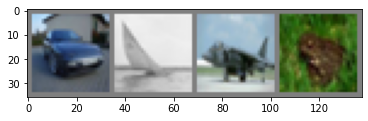

  car  ship plane  frog


In [84]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 4.2 Creating and training the network

Let us reuse the network from section 3 by modifying it a bit for this data.

In [85]:
# 1. Define network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

# 2. Define loss and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 3. Training 
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

# 4. Save model
PATH = './models/cifar_net.pth'
torch.save(net.state_dict(), PATH)

[1,  2000] loss: 2.214
[1,  4000] loss: 1.886
[1,  6000] loss: 1.710
[1,  8000] loss: 1.615
[1, 10000] loss: 1.541
[1, 12000] loss: 1.499
[2,  2000] loss: 1.424
[2,  4000] loss: 1.392
[2,  6000] loss: 1.374
[2,  8000] loss: 1.343
[2, 10000] loss: 1.308
[2, 12000] loss: 1.306
Finished Training


### 4.3 Testing the network on the test set

#### 4.3.1 Testing on some examples

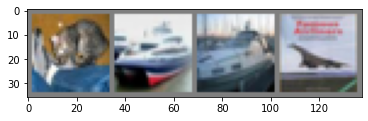

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship  ship


In [91]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 1. Reload model 
net = Net()
net.load_state_dict(torch.load(PATH))

# 2. Get outputs 
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

#### 4.3.2 Testing on the whole test set

In [89]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


#### 4.3.3 See performance per class

In [92]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 69 %
Accuracy of   car : 73 %
Accuracy of  bird : 32 %
Accuracy of   cat : 27 %
Accuracy of  deer : 54 %
Accuracy of   dog : 47 %
Accuracy of  frog : 62 %
Accuracy of horse : 63 %
Accuracy of  ship : 73 %
Accuracy of truck : 58 %
